# Variance "Wiggles" in Cell-Based Coadds

An invesitgation into variance "wiggles" found in tract 9813.

## Imports and definitions

In [32]:
REPO = '/sdf/data/rubin/repo/main/'

from lsst.daf.butler import Butler
import lsst.afw.image as afwImage
import lsst.geom as afwGeom
from lsst.skymap import Index2D
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import gc

%matplotlib inline

butler = Butler(REPO)
registry = butler.registry

In [2]:
collection = 'u/mgorsuch/cell_coadds_tract_9813_d_2024_08_27/20240904T143002Z'
hsc_collection = 'HSC/runs/RC2_subset/d_2024_08_27'

## Find patches with visable wiggles

In [3]:
coadd = butler.get('deepCoaddCell', 
                     collections=collection, 
                     instrument='HSC', 
                     skymap = 'hsc_rings_cells_v1', 
                     tract = 9813, 
                     patch=61,
                     band='i',)

In [4]:
wcs = coadd.wcs

In [5]:
ra_list = [150.1, 150.0, 150.4, 150.4, 150.4, 150.0, 149.85, 149.95, 149.85]
dec_list = [2.5, 2.5, 2.4, 2.2, 2.1, 2.1, 2.1, 2.0, 2.0]

In [6]:
patch_list = []

for ref in butler.registry.queryDatasets('deepCoaddCell', physical_filter='HSC-I', collections=collection, instrument='HSC'):
    patch = ref.dataId["patch"]
    coadd = butler.get('deepCoaddCell', 
                     collections=collection, 
                     instrument='HSC', 
                     skymap = 'hsc_rings_cells_v1', 
                     tract = 9813, 
                     patch=patch,
                     band='i',)
    for i in range(len(ra_list)):
        test_ra = afwGeom.Angle(ra_list[i] * np.pi / 180)
        test_dec = afwGeom.Angle(dec_list[i] * np.pi / 180)
        thing = afwGeom.SpherePoint(test_ra, test_dec)
        center = wcs.skyToPixel(thing)
        test = coadd.inner_bbox.contains(center[0], center[1])
        if test:
            print(f"Ra: {ra_list[i]}, Dec: {dec_list[i]}, Patch {patch}")
            patch_list.append(patch)
    del coadd
    gc.collect()

Ra: 150.1, Dec: 2.5, Patch 83
Ra: 149.85, Dec: 2.0, Patch 41
Ra: 150.0, Dec: 2.5, Patch 84
Ra: 150.0, Dec: 2.1, Patch 51
Ra: 150.4, Dec: 2.2, Patch 59
Ra: 149.85, Dec: 2.1, Patch 52
Ra: 150.4, Dec: 2.1, Patch 48
Ra: 150.4, Dec: 2.4, Patch 70
Ra: 149.95, Dec: 2.0, Patch 40


## Visualize variance planes

In [3]:
import lsst.afw.display as afwDisplay
afwDisplay.setDefaultBackend('firefly')

In [26]:
coadd = butler.get('deepCoaddCell', 
                     collections=collection, 
                     instrument='HSC', 
                     skymap = 'hsc_rings_cells_v1', 
                     tract = 9813, 
                     patch=patch_list[4],
                     band='i',)

stitched_coadd = coadd.stitch()

In [21]:
patch_list[4]

59

In [59]:
display1 = afwDisplay.Display(frame=1)
display1.mtv(stitched_coadd.asMaskedImage())
display2 = afwDisplay.Display(frame=2)
display2.mtv(stitched_coadd.variance)

Appears to be a bright star. It would be good to verify in the warp or calexp.

### Patch 59

In [64]:
visits = []
for ref in butler.registry.queryDatasets('deepCoadd_directWarp', physical_filter='HSC-I', collections=collection, instrument='HSC', tract=9813, skymap = 'hsc_rings_cells_v1', patch=59):
    visits.append(ref.dataId.get('visit'))
visits = np.unique(visits)
print(visits)

[ 1242 19684 19694 19696 30482 30490]


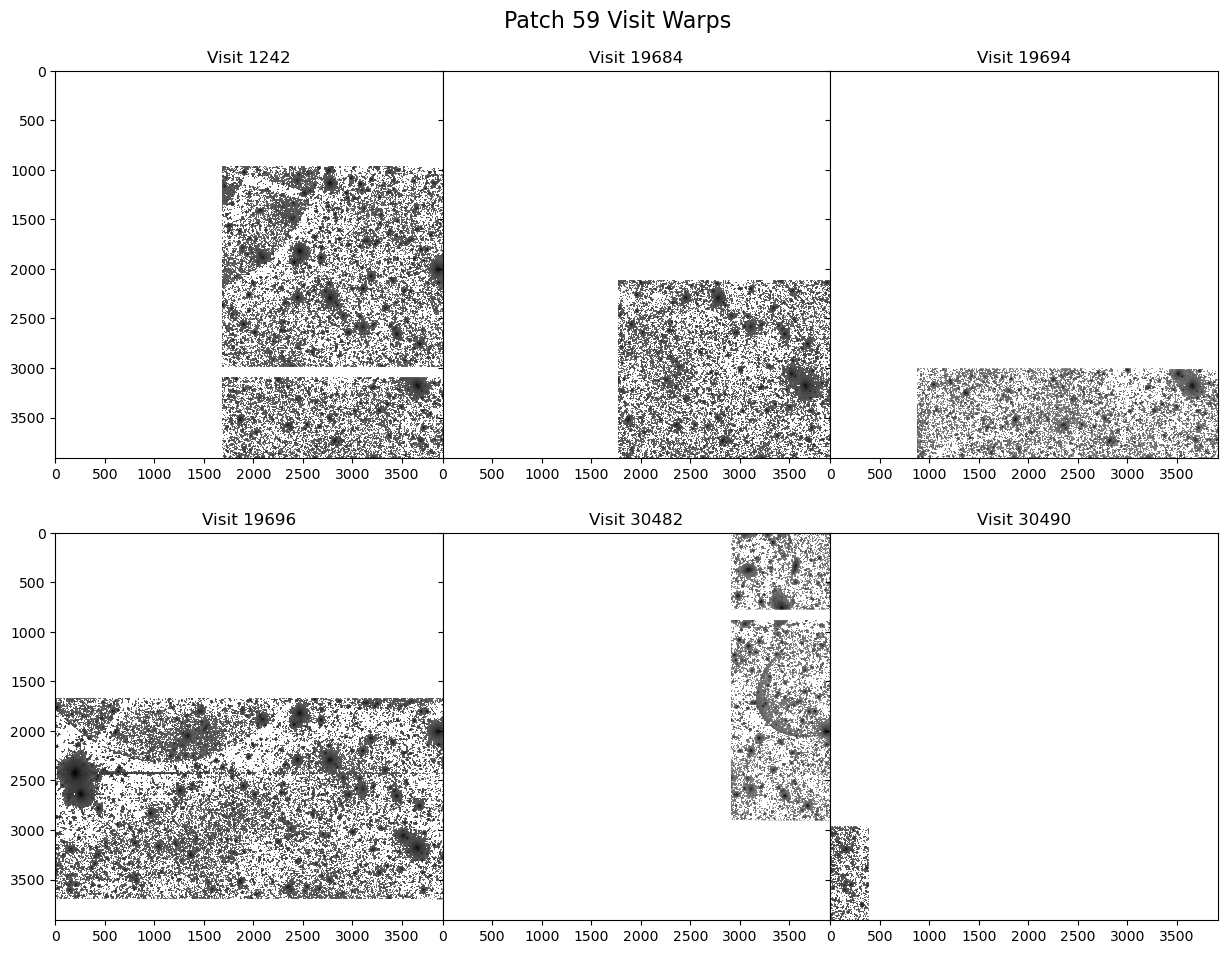

In [65]:
fig, axs = plt.subplots(2, 3, figsize=(15,12), gridspec_kw = {'wspace':0, 'hspace':0}, sharey=True)

for ax_index, ax in enumerate(axs.flat):

    warp = butler.get('deepCoadd_directWarp',
                   collections = collection,
                   instrument='HSC',
                   skymap = 'hsc_rings_cells_v1',
                   tract = 9813,
                   patch = 59,
                   visit = visits[ax_index])

    stitched_image = ax.imshow(np.flip(warp.image.array, axis=0),
                     cmap='gray_r',
                     norm='log',)

    ax.set_title(f"Visit {visits[ax_index]}")
    # ax.label_outer()

    del warp
    gc.collect()

fig.suptitle("Patch 59 Visit Warps", fontsize=16, x=0.5, y=0.90)
# plt.savefig('variance-wiggles-coadd-patch59.png', bbox_inches='tight')
plt.show()

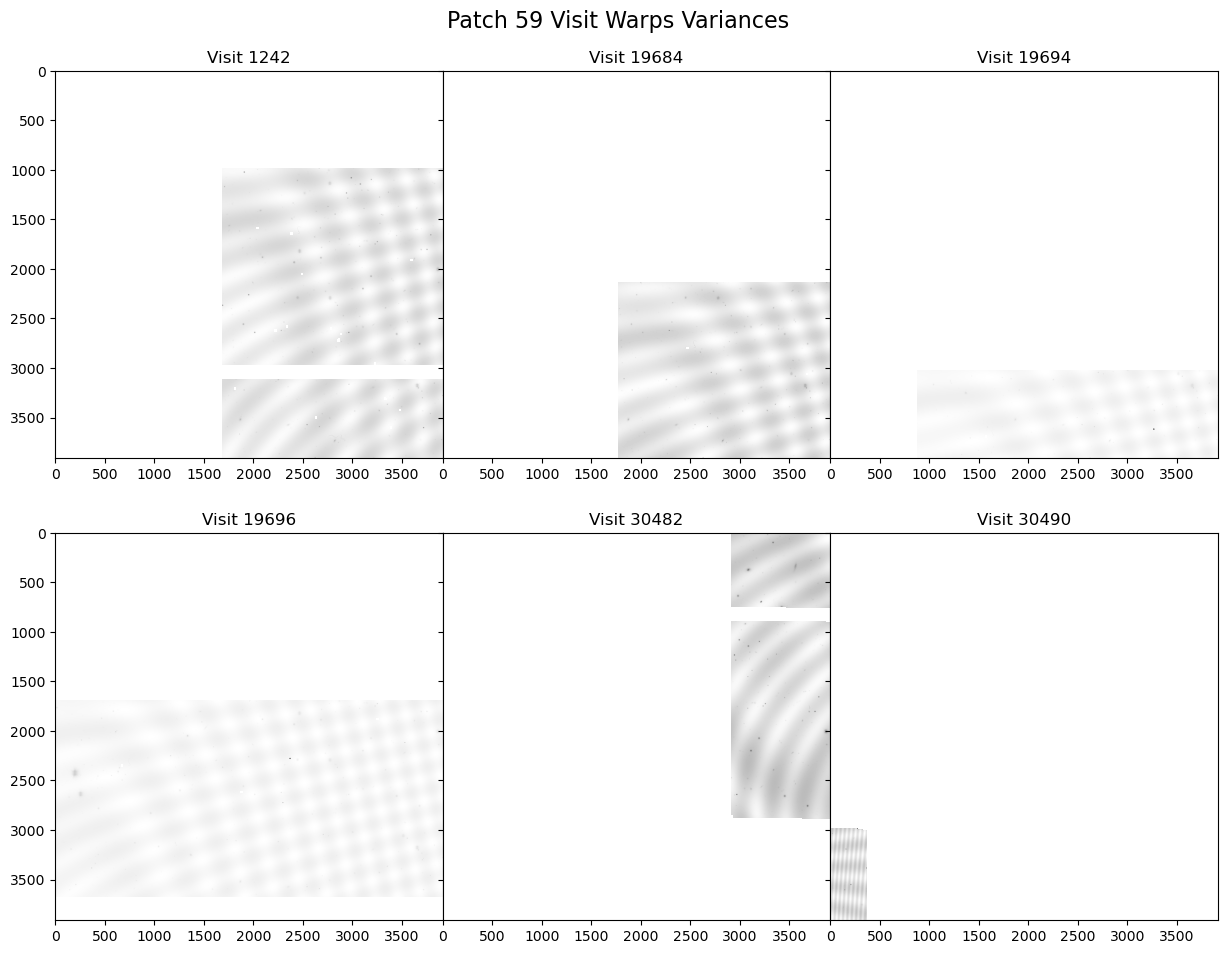

In [57]:
fig, axs = plt.subplots(2, 3, figsize=(15,12), gridspec_kw = {'wspace':0, 'hspace':0}, sharey=True)

for ax_index, ax in enumerate(axs.flat):

    warp = butler.get('deepCoadd_directWarp',
                   collections = collection,
                   instrument='HSC',
                   skymap = 'hsc_rings_cells_v1',
                   tract = 9813,
                   patch = 59,
                   visit = visits[ax_index])

    stitched_image = ax.imshow(np.flip(warp.variance.array, axis=0),
                     cmap='gray_r',
                     norm='log',)

    ax.set_title(f"Visit {visits[ax_index]}")
    # ax.label_outer()

    del warp
    gc.collect()

fig.suptitle("Patch 59 Visit Warps Variances", fontsize=16, x=0.5, y=0.90)
# plt.savefig('variance-wiggles-var-patch59.png', bbox_inches='tight')
plt.show()

### Patch 40

In [31]:
patch = 40
visits = []
for ref in butler.registry.queryDatasets('deepCoadd_directWarp', physical_filter='HSC-I', collections=collection, instrument='HSC', tract=9813, skymap = 'hsc_rings_cells_v1', patch=patch):
    visits.append(ref.dataId.get('visit'))
visits = np.unique(visits)
print(visits)

[19684 19694 30490]


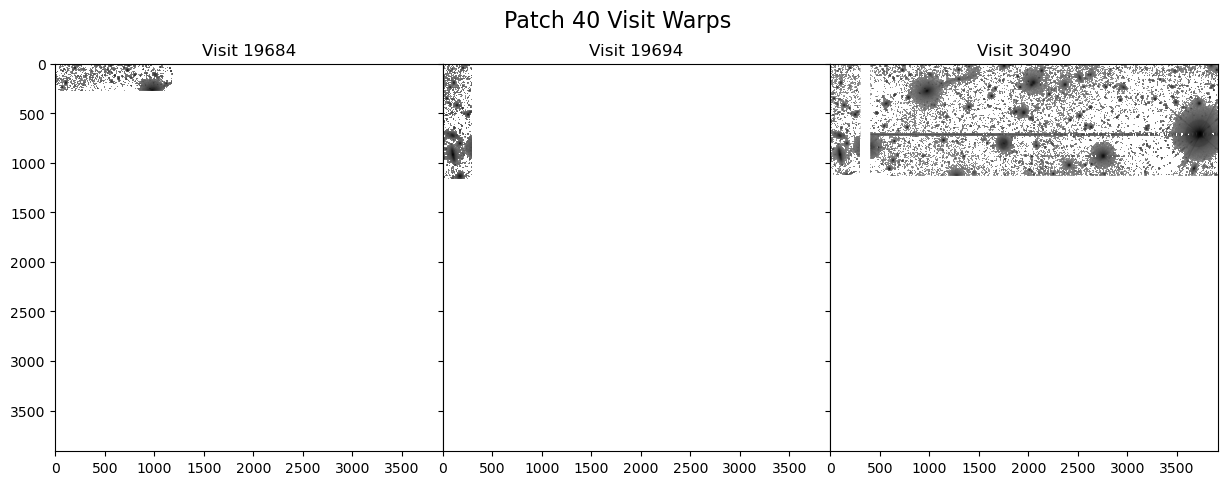

In [34]:
fig, axs = plt.subplots(1, 3, figsize=(15,7), gridspec_kw = {'wspace':0, 'hspace':0}, sharey=True)

for ax_index, ax in enumerate(axs.flat):

    warp = butler.get('deepCoadd_directWarp',
                   collections = collection,
                   instrument='HSC',
                   skymap = 'hsc_rings_cells_v1',
                   tract = 9813,
                   patch = patch,
                   visit = visits[ax_index])

    stitched_image = ax.imshow(np.flip(warp.image.array, axis=0),
                     cmap='gray_r',
                     norm='log',)

    ax.set_title(f"Visit {visits[ax_index]}")
    # ax.label_outer()

    del warp
    gc.collect()

fig.suptitle(f"Patch {patch} Visit Warps", fontsize=16, x=0.5, y=0.85)
# plt.savefig('variance-wiggles-coadd-patch59.png', bbox_inches='tight')
plt.show()

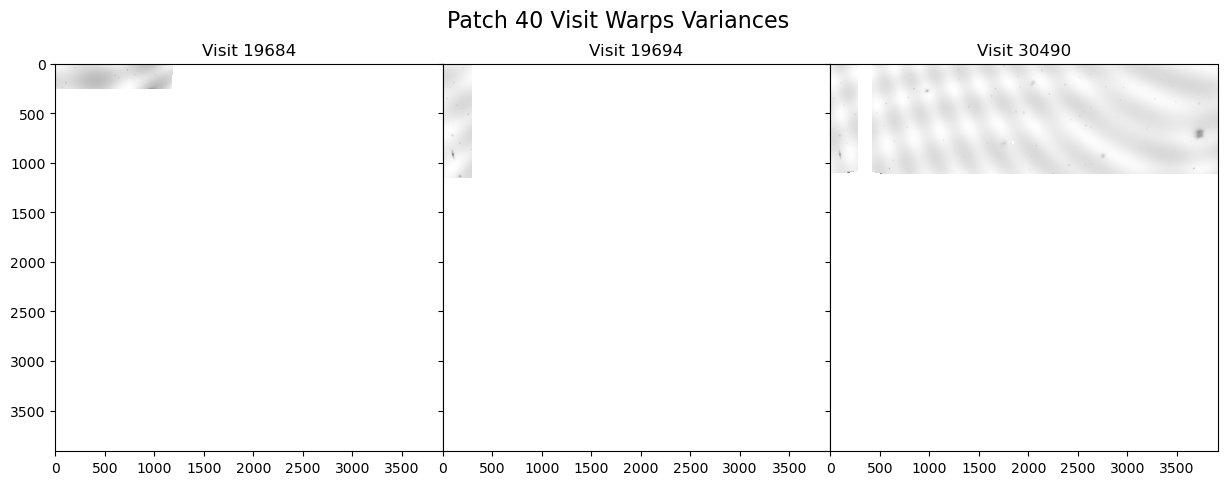

In [35]:
fig, axs = plt.subplots(1, 3, figsize=(15,7), gridspec_kw = {'wspace':0, 'hspace':0}, sharey=True)

for ax_index, ax in enumerate(axs.flat):

    warp = butler.get('deepCoadd_directWarp',
                   collections = collection,
                   instrument='HSC',
                   skymap = 'hsc_rings_cells_v1',
                   tract = 9813,
                   patch = patch,
                   visit = visits[ax_index])

    stitched_image = ax.imshow(np.flip(warp.variance.array, axis=0),
                     cmap='gray_r',
                     norm='log',)

    ax.set_title(f"Visit {visits[ax_index]}")
    # ax.label_outer()

    del warp
    gc.collect()

fig.suptitle(f"Patch {patch} Visit Warps Variances", fontsize=16, x=0.5, y=0.85)
# plt.savefig('variance-wiggles-var-patch59.png', bbox_inches='tight')
plt.show()

### Patch 41

In [36]:
patch = 41
visits = []
for ref in butler.registry.queryDatasets('deepCoadd_directWarp', physical_filter='HSC-I', collections=collection, instrument='HSC', tract=9813, skymap = 'hsc_rings_cells_v1', patch=patch):
    visits.append(ref.dataId.get('visit'))
visits = np.unique(visits)
print(visits)

[30490]


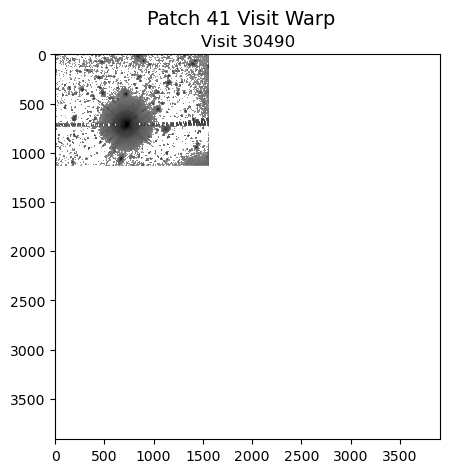

In [47]:
fig, axs = plt.subplots(1, 1, figsize=(5,5), gridspec_kw = {'wspace':0, 'hspace':0}, sharey=True)

for ax_index, ax in enumerate([axs]):

    warp = butler.get('deepCoadd_directWarp',
                   collections = collection,
                   instrument='HSC',
                   skymap = 'hsc_rings_cells_v1',
                   tract = 9813,
                   patch = patch,
                   visit = visits[ax_index])

    stitched_image = ax.imshow(np.flip(warp.image.array, axis=0),
                     cmap='gray_r',
                     norm='log',)

    ax.set_title(f"Visit {visits[ax_index]}")
    # ax.label_outer()

    del warp
    gc.collect()

fig.suptitle(f"Patch {patch} Visit Warp", fontsize=14, x=0.5, y=0.97)
# plt.savefig('variance-wiggles-coadd-patch59.png', bbox_inches='tight')
plt.show()

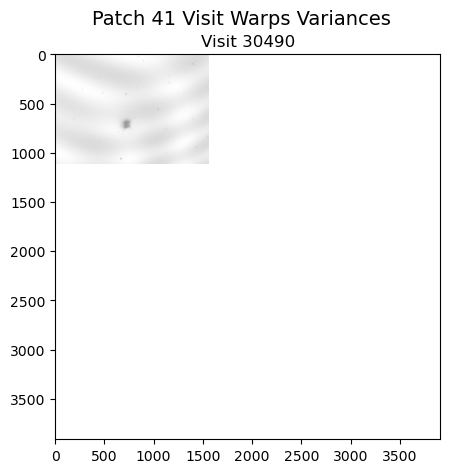

In [49]:
fig, axs = plt.subplots(1, 1, figsize=(5,5), gridspec_kw = {'wspace':0, 'hspace':0}, sharey=True)

for ax_index, ax in enumerate([axs]):

    warp = butler.get('deepCoadd_directWarp',
                   collections = collection,
                   instrument='HSC',
                   skymap = 'hsc_rings_cells_v1',
                   tract = 9813,
                   patch = patch,
                   visit = visits[ax_index])

    stitched_image = ax.imshow(np.flip(warp.variance.array, axis=0),
                     cmap='gray_r',
                     norm='log',)

    ax.set_title(f"Visit {visits[ax_index]}")
    # ax.label_outer()

    del warp
    gc.collect()

fig.suptitle(f"Patch {patch} Visit Warps Variances", fontsize=14, x=0.5, y=0.97)
# plt.savefig('variance-wiggles-var-patch59.png', bbox_inches='tight')
plt.show()

### Patch 48

In [50]:
patch = 48
visits = []
for ref in butler.registry.queryDatasets('deepCoadd_directWarp', physical_filter='HSC-I', collections=collection, instrument='HSC', tract=9813, skymap = 'hsc_rings_cells_v1', patch=patch):
    visits.append(ref.dataId.get('visit'))
visits = np.unique(visits)
print(visits)

[ 1242 19684 19694 19696 30490]


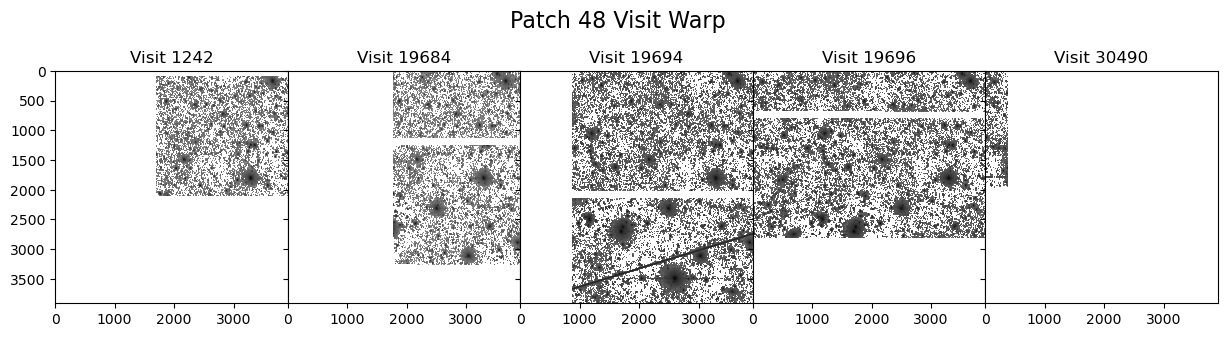

In [55]:
fig, axs = plt.subplots(1, 5, figsize=(15,5), gridspec_kw = {'wspace':0, 'hspace':0}, sharey=True)

for ax_index, ax in enumerate(axs.flat):

    warp = butler.get('deepCoadd_directWarp',
                   collections = collection,
                   instrument='HSC',
                   skymap = 'hsc_rings_cells_v1',
                   tract = 9813,
                   patch = patch,
                   visit = visits[ax_index])

    stitched_image = ax.imshow(np.flip(warp.image.array, axis=0),
                     cmap='gray_r',
                     norm='log',)

    ax.set_title(f"Visit {visits[ax_index]}")
    # ax.label_outer()

    del warp
    gc.collect()

fig.suptitle(f"Patch {patch} Visit Warp", fontsize=16, x=0.5, y=0.85)
# plt.savefig('variance-wiggles-coadd-patch59.png', bbox_inches='tight')
plt.show()

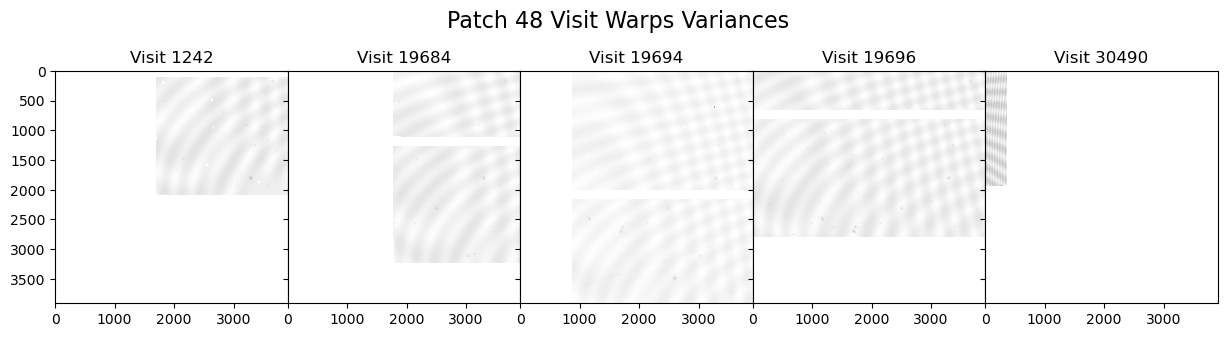

In [57]:
fig, axs = plt.subplots(1, 5, figsize=(15,5), gridspec_kw = {'wspace':0, 'hspace':0}, sharey=True)

for ax_index, ax in enumerate(axs.flat):

    warp = butler.get('deepCoadd_directWarp',
                   collections = collection,
                   instrument='HSC',
                   skymap = 'hsc_rings_cells_v1',
                   tract = 9813,
                   patch = patch,
                   visit = visits[ax_index])

    stitched_image = ax.imshow(np.flip(warp.variance.array, axis=0),
                     cmap='gray_r',
                     norm='log',)

    ax.set_title(f"Visit {visits[ax_index]}")
    # ax.label_outer()

    del warp
    gc.collect()

fig.suptitle(f"Patch {patch} Visit Warps Variances", fontsize=16, x=0.5, y=0.85)
# plt.savefig('variance-wiggles-var-patch59.png', bbox_inches='tight')
plt.show()

### Patch 52

In [3]:
visits = []
for ref in butler.registry.queryDatasets('deepCoadd_directWarp', physical_filter='HSC-I', collections=collection, instrument='HSC', tract=9813, skymap = 'hsc_rings_cells_v1', patch=52):
    visits.append(ref.dataId.get('visit'))
visits = np.unique(visits)
print(visits)

[ 1248 19680 30490]


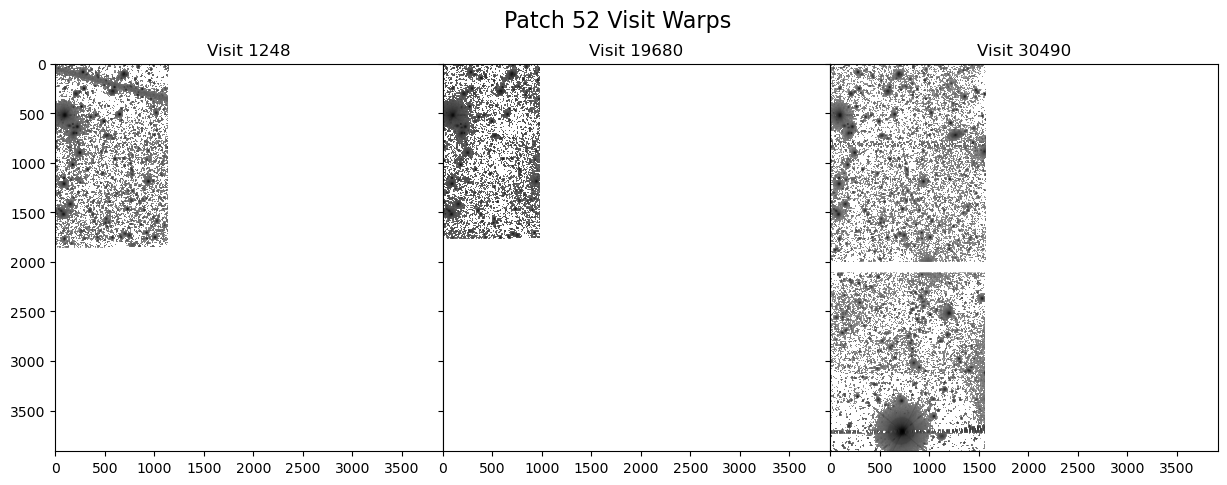

In [11]:
fig, axs = plt.subplots(1, 3, figsize=(15,7), gridspec_kw = {'wspace':0, 'hspace':0}, sharey=True)

for ax_index, ax in enumerate(axs.flat):

    warp = butler.get('deepCoadd_directWarp',
                   collections = collection,
                   instrument='HSC',
                   skymap = 'hsc_rings_cells_v1',
                   tract = 9813,
                   patch = 52,
                   visit = visits[ax_index])

    stitched_image = ax.imshow(np.flip(warp.image.array, axis=0),
                     cmap='gray_r',
                     norm='log',)

    ax.set_title(f"Visit {visits[ax_index]}")
    # ax.label_outer()

    del warp
    gc.collect()

fig.suptitle("Patch 52 Visit Warps", fontsize=16, x=0.50, y=0.85)
# plt.savefig('variance-wiggles-coadd-patch52.png', bbox_inches='tight')
plt.show()

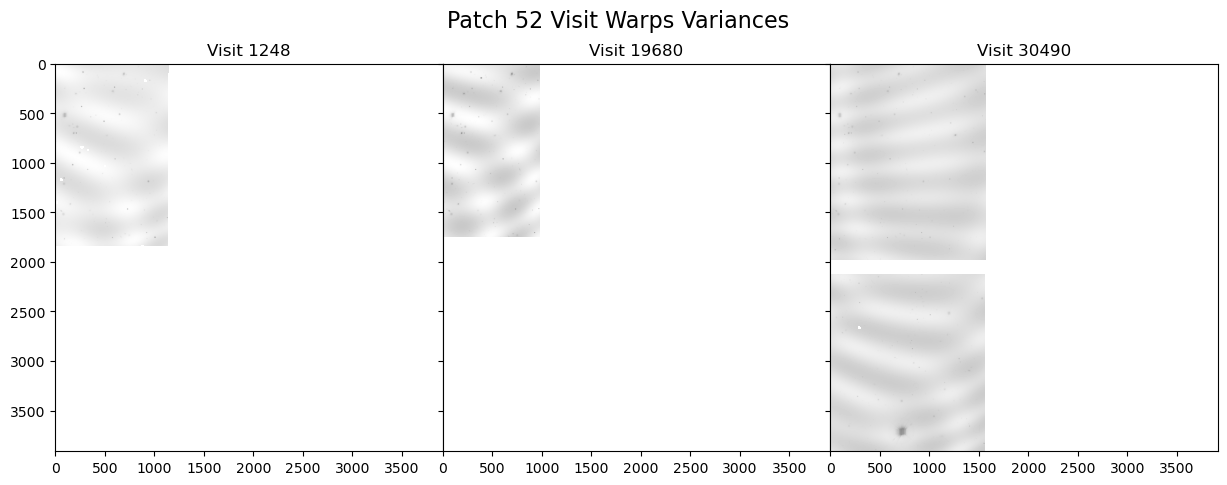

In [9]:
fig, axs = plt.subplots(1, 3, figsize=(15,7), gridspec_kw = {'wspace':0, 'hspace':0}, sharey=True)

for ax_index, ax in enumerate(axs.flat):

    warp = butler.get('deepCoadd_directWarp',
                   collections = collection,
                   instrument='HSC',
                   skymap = 'hsc_rings_cells_v1',
                   tract = 9813,
                   patch = 52,
                   visit = visits[ax_index])

    stitched_image = ax.imshow(np.flip(warp.variance.array, axis=0),
                     cmap='gray_r',
                     norm='log',)

    ax.set_title(f"Visit {visits[ax_index]}")
    # ax.label_outer()

    del warp
    gc.collect()

fig.suptitle("Patch 52 Visit Warps Variances", fontsize=16, x=0.5, y=0.85)
# plt.savefig('variance-wiggles-var-patch52.png', bbox_inches='tight')
plt.show()

### Patch 61

In [67]:
patch = 61
visits = []
for ref in butler.registry.queryDatasets('deepCoadd_directWarp', physical_filter='HSC-I', collections=collection, instrument='HSC', tract=9813, skymap = 'hsc_rings_cells_v1', patch=patch):
    visits.append(ref.dataId.get('visit'))
visits = np.unique(visits)
print(visits)

[ 1242  1248 19680 19684 19694 19696 30482 30490]


In [68]:
coadd = butler.get('deepCoaddCell', 
                     collections=collection, 
                     instrument='HSC', 
                     skymap = 'hsc_rings_cells_v1', 
                     tract = 9813, 
                     patch=patch,
                     band='i',)

stitched_coadd = coadd.stitch()

In [69]:
display1 = afwDisplay.Display(frame=1)
display1.mtv(stitched_coadd.asMaskedImage())
display2 = afwDisplay.Display(frame=2)
display2.mtv(stitched_coadd.variance)

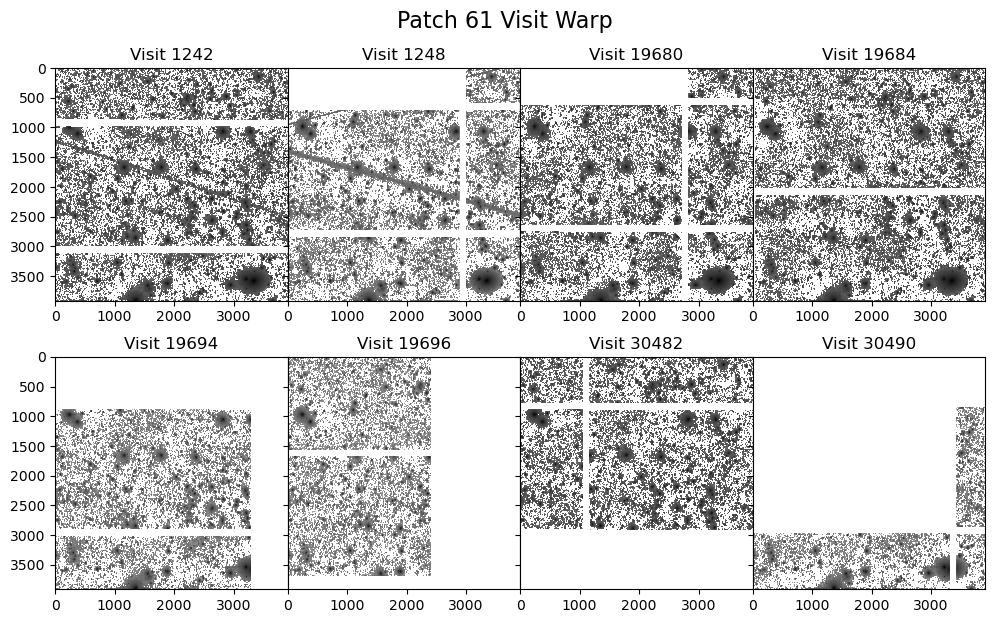

In [73]:
fig, axs = plt.subplots(2, 4, figsize=(12,7.5), gridspec_kw = {'wspace':0, 'hspace':0}, sharey=True)

for ax_index, ax in enumerate(axs.flat):

    warp = butler.get('deepCoadd_directWarp',
                   collections = collection,
                   instrument='HSC',
                   skymap = 'hsc_rings_cells_v1',
                   tract = 9813,
                   patch = patch,
                   visit = visits[ax_index])

    stitched_image = ax.imshow(np.flip(warp.image.array, axis=0),
                     cmap='gray_r',
                     norm='log',)

    ax.set_title(f"Visit {visits[ax_index]}")
    # ax.label_outer()

    del warp
    gc.collect()

fig.suptitle(f"Patch {patch} Visit Warp", fontsize=16, x=0.5, y=0.92)
# plt.savefig('variance-wiggles-coadd-patch59.png', bbox_inches='tight')
plt.show()

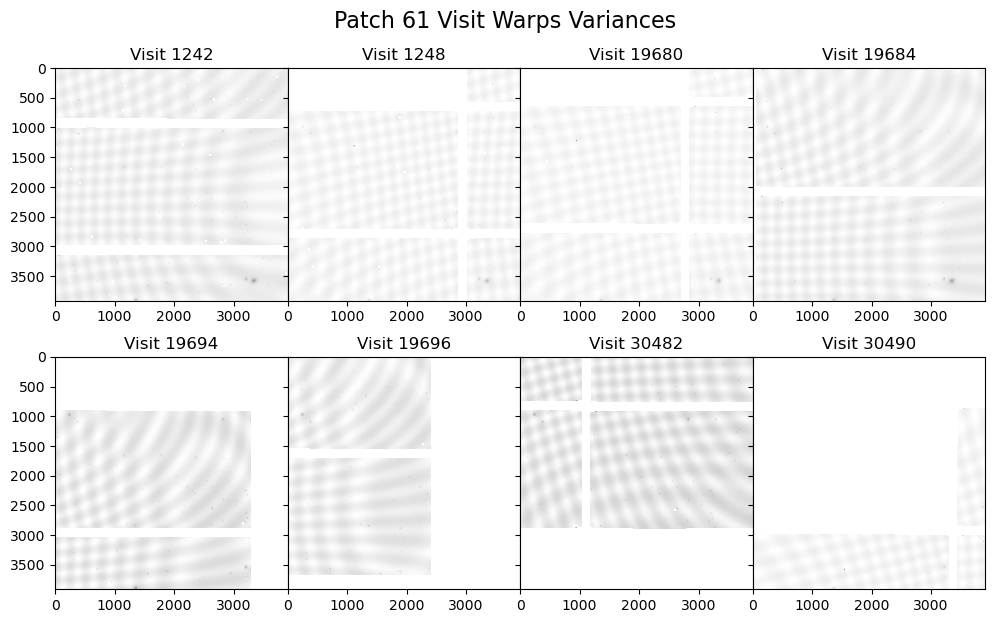

In [74]:
fig, axs = plt.subplots(2, 4, figsize=(12,7.5), gridspec_kw = {'wspace':0, 'hspace':0}, sharey=True)

for ax_index, ax in enumerate(axs.flat):

    warp = butler.get('deepCoadd_directWarp',
                   collections = collection,
                   instrument='HSC',
                   skymap = 'hsc_rings_cells_v1',
                   tract = 9813,
                   patch = patch,
                   visit = visits[ax_index])

    stitched_image = ax.imshow(np.flip(warp.variance.array, axis=0),
                     cmap='gray_r',
                     norm='log',)

    ax.set_title(f"Visit {visits[ax_index]}")
    # ax.label_outer()

    del warp
    gc.collect()

fig.suptitle(f"Patch {patch} Visit Warps Variances", fontsize=16, x=0.5, y=0.92)
# plt.savefig('variance-wiggles-var-patch59.png', bbox_inches='tight')
plt.show()

### Detectors

From the first three visits in patch 61, the pattern in variance appears to be a detector artifact. Attempt to find the calexp that have these detectors and look at their variance planes.

In [ ]:
all_detectors = []

detector = []
for ref in butler.registry.queryDatasets('calexp', 
                                         physical_filter='HSC-I', 
                                         collections=hsc_collection, 
                                         instrument='HSC', 
                                         skymap = 'hsc_rings_cells_v1',
                                         tract=9813,
                                         patch=61,
                                         visit=1242):
    
    detector.append(ref.dataId['detector'])
    all_detectors.append(ref.dataId['detector'])
print("Visit 1242: ", np.unique(detector))

detector = []
for ref in butler.registry.queryDatasets('calexp', 
                                         physical_filter='HSC-I', 
                                         collections=hsc_collection, 
                                         instrument='HSC', 
                                         skymap = 'hsc_rings_cells_v1',
                                         tract=9813,
                                         patch=61,
                                         visit=1248):
    
    detector.append(ref.dataId['detector'])
    all_detectors.append(ref.dataId['detector'])
print("Visit 1248: ", np.unique(detector))

detector = []
for ref in butler.registry.queryDatasets('calexp', 
                                         physical_filter='HSC-I', 
                                         collections=hsc_collection, 
                                         instrument='HSC', 
                                         skymap = 'hsc_rings_cells_v1',
                                         tract=9813,
                                         patch=61,
                                         visit=19680):
    
    detector.append(ref.dataId['detector'])
    all_detectors.append(ref.dataId['detector'])
print("Visit 19680: ", np.unique(detector))

detector = []
for ref in butler.registry.queryDatasets('calexp', 
                                         physical_filter='HSC-I', 
                                         collections=hsc_collection, 
                                         instrument='HSC', 
                                         skymap = 'hsc_rings_cells_v1',
                                         tract=9813,
                                         patch=61,
                                         visit=19684):
    
    detector.append(ref.dataId['detector'])
    all_detectors.append(ref.dataId['detector'])
print("Visit 19684: ", np.unique(detector))

print()
print("All detectors for these visits: ", np.unique(all_detectors))

Visit 1242:  [42 50 58]
Visit 1248:  [41 42 49 50 58]
Visit 19680:  [41 42 49 50 58]
Visit 19684:  [50 58]

All detectors for these visits:  [41 42 49 50 58]


In [152]:
cal = butler.get('calexp',
                   collections = hsc_collection,
                   instrument='HSC',
                   band = 'i',
                   tract = 9813,
                   patch = 61,
                   visit = 19684,
                   detector = 58)

In [115]:
display1 = afwDisplay.Display(frame=1)
display1.mtv(cal.image)
display2 = afwDisplay.Display(frame=2)
display2.mtv(cal.variance)

### Default Coadds

Try a normal coadd...

In [83]:
rc2_collection = 'HSC/runs/RC2/w_2024_30/DM-45425c'

In [146]:
for datasetType in registry.queryDatasetTypes():
    if registry.queryDatasets(datasetType, collections=hsc_collection).any(execute=False, exact=False):
        print(datasetType)

DatasetType('skyMap', {skymap}, SkyMap)
DatasetType('raw', {band, instrument, day_obs, detector, group, physical_filter, exposure}, Exposure)
DatasetType('camera', {instrument}, Camera, isCalibration=True)
DatasetType('defects', {instrument, detector}, Defects, isCalibration=True)
DatasetType('bfKernel', {instrument}, NumpyArray, isCalibration=True)
DatasetType('transmission_optics', {instrument}, TransmissionCurve, isCalibration=True)
DatasetType('transmission_sensor', {instrument, detector}, TransmissionCurve, isCalibration=True)
DatasetType('transmission_filter', {band, instrument, physical_filter}, TransmissionCurve, isCalibration=True)
DatasetType('transmission_atmosphere', {instrument}, TransmissionCurve, isCalibration=True)
DatasetType('sky', {band, instrument, detector, physical_filter}, ExposureF, isCalibration=True)
DatasetType('bias', {instrument, detector}, ExposureF, isCalibration=True)
DatasetType('flat', {band, instrument, detector, physical_filter}, ExposureF, isCalibra

In [40]:
for ref in butler.registry.queryDatasets('deepCoadd', physical_filter='HSC-I', collections=rc2_collection, instrument='HSC', tract=9813, band='i', skymap = 'hsc_rings_v1'):
    print(ref.dataId)

{band: 'i', skymap: 'hsc_rings_v1', tract: 9813, patch: 1}
{band: 'i', skymap: 'hsc_rings_v1', tract: 9813, patch: 2}
{band: 'i', skymap: 'hsc_rings_v1', tract: 9813, patch: 3}
{band: 'i', skymap: 'hsc_rings_v1', tract: 9813, patch: 4}
{band: 'i', skymap: 'hsc_rings_v1', tract: 9813, patch: 5}
{band: 'i', skymap: 'hsc_rings_v1', tract: 9813, patch: 6}
{band: 'i', skymap: 'hsc_rings_v1', tract: 9813, patch: 7}
{band: 'i', skymap: 'hsc_rings_v1', tract: 9813, patch: 8}
{band: 'i', skymap: 'hsc_rings_v1', tract: 9813, patch: 9}
{band: 'i', skymap: 'hsc_rings_v1', tract: 9813, patch: 10}
{band: 'i', skymap: 'hsc_rings_v1', tract: 9813, patch: 11}
{band: 'i', skymap: 'hsc_rings_v1', tract: 9813, patch: 12}
{band: 'i', skymap: 'hsc_rings_v1', tract: 9813, patch: 13}
{band: 'i', skymap: 'hsc_rings_v1', tract: 9813, patch: 14}
{band: 'i', skymap: 'hsc_rings_v1', tract: 9813, patch: 15}
{band: 'i', skymap: 'hsc_rings_v1', tract: 9813, patch: 16}
{band: 'i', skymap: 'hsc_rings_v1', tract: 9813, 

In [78]:
default_coadd = butler.get('deepCoadd', 
                     collections=rc2_collection, 
                     instrument='HSC', 
                     skymap = 'hsc_rings_v1', 
                     tract = 9813, 
                     patch= 61,
                     band='i',)

In [79]:
display1 = afwDisplay.Display(frame=1)
display1.mtv(default_coadd.image)
display2 = afwDisplay.Display(frame=2)
display2.mtv(default_coadd.variance)

In [68]:
patch = 61
visits = []
for ref in butler.registry.queryDatasets('deepCoadd_directWarp', 
                                         physical_filter='HSC-I', 
                                         collections=rc2_collection, 
                                         instrument='HSC', 
                                         tract=9813, skymap = 'hsc_rings_v1', 
                                         patch=patch):
    visits.append(ref.dataId.get('visit'))
visits = np.unique(visits)
print(visits)

[ 1228  1230  1232  1238  1240  1242  1244  1246  1248 19658 19660 19662
 19680 19682 19684 19694 19696 19698 19708 19710 19712 30482 30484 30486
 30488 30490 30492 30494 30496 30498 30500 30502 30504]


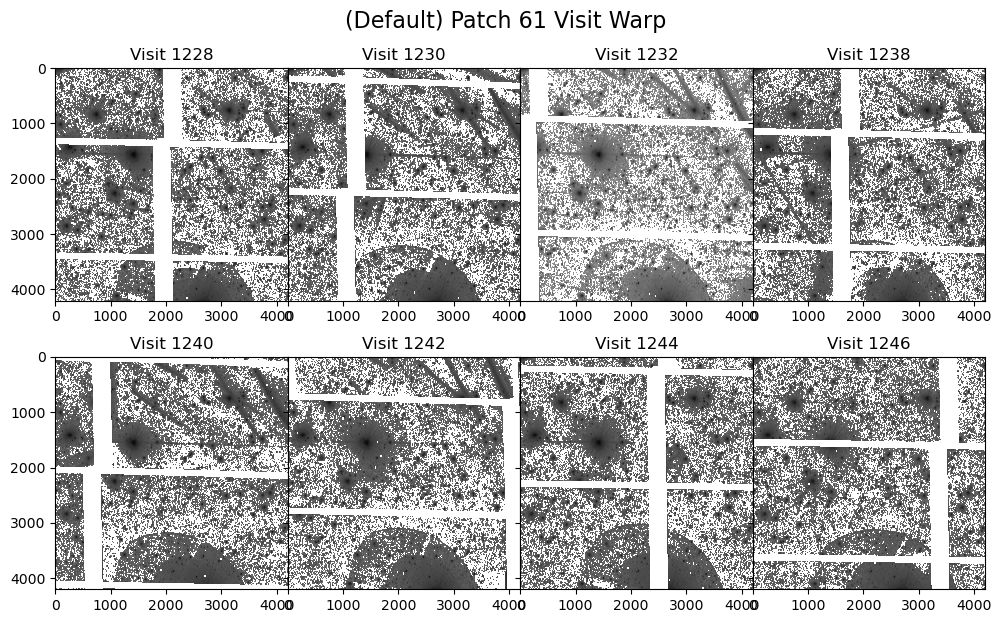

In [70]:
fig, axs = plt.subplots(2, 4, figsize=(12,7.5), gridspec_kw = {'wspace':0, 'hspace':0}, sharey=True)

for ax_index, ax in enumerate(axs.flat):

    warp = butler.get('deepCoadd_directWarp',
                   collections = rc2_collection,
                   instrument='HSC',
                   skymap = 'hsc_rings_v1',
                   tract = 9813,
                   patch = patch,
                   visit = visits[ax_index])

    stitched_image = ax.imshow(np.flip(warp.image.array, axis=0),
                     cmap='gray_r',
                     norm='log',)

    ax.set_title(f"Visit {visits[ax_index]}")
    # ax.label_outer()

    del warp
    gc.collect()

fig.suptitle(f"(Default) Patch {patch} Visit Warp", fontsize=16, x=0.5, y=0.92)
# plt.savefig('variance-wiggles-coadd-patch59.png', bbox_inches='tight')
plt.show()

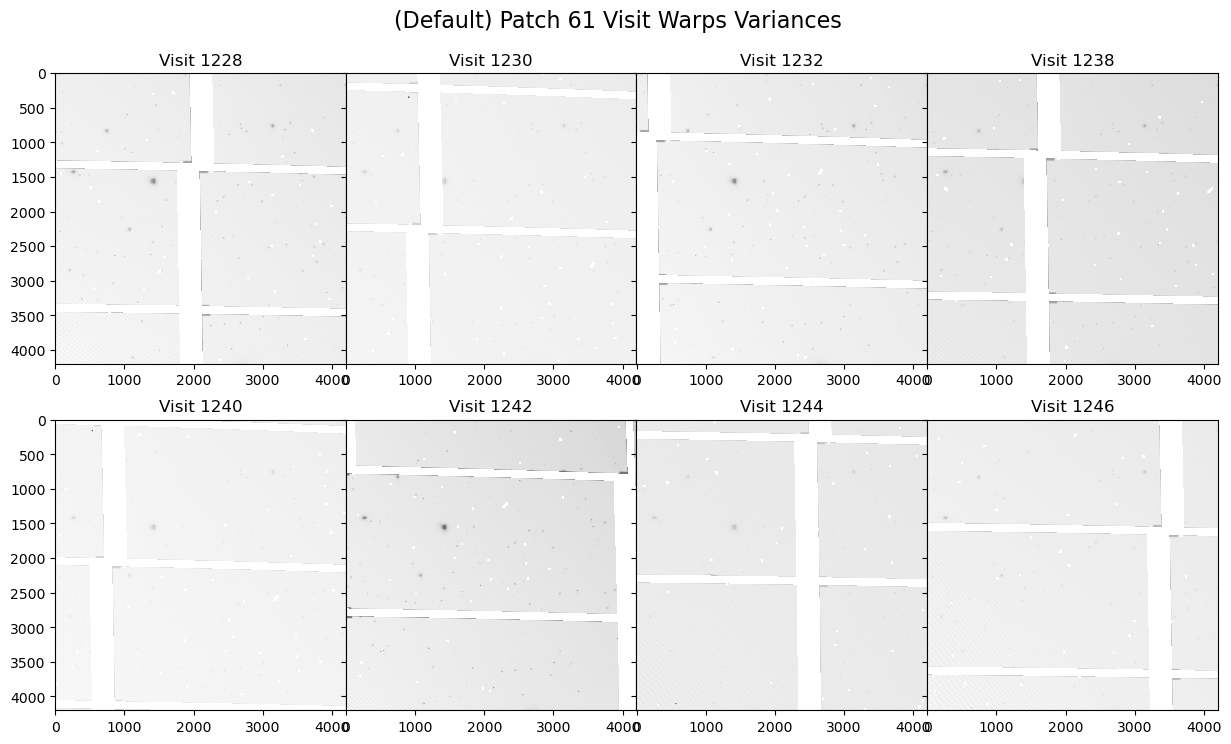

In [72]:
fig, axs = plt.subplots(2, 4, figsize=(15,9), gridspec_kw = {'wspace':0, 'hspace':0}, sharey=True)

for ax_index, ax in enumerate(axs.flat):

    warp = butler.get('deepCoadd_directWarp',
                   collections = rc2_collection,
                   instrument='HSC',
                   skymap = 'hsc_rings_v1',
                   tract = 9813,
                   patch = patch,
                   visit = visits[ax_index])

    stitched_image = ax.imshow(np.flip(warp.variance.array, axis=0),
                     cmap='gray_r',
                     norm='log',)

    ax.set_title(f"Visit {visits[ax_index]}")
    # ax.label_outer()

    del warp
    gc.collect()

fig.suptitle(f"(Default) Patch {patch} Visit Warps Variances", fontsize=16, x=0.5, y=0.92)
# plt.savefig('variance-wiggles-var-patch59.png', bbox_inches='tight')
plt.show()

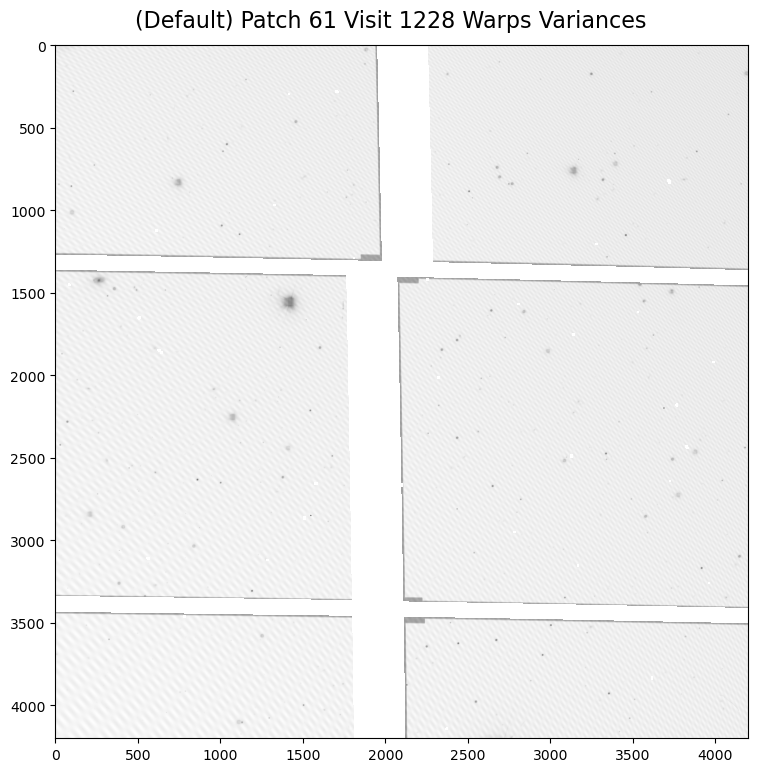

In [77]:
warp = butler.get('deepCoadd_directWarp',
                   collections = rc2_collection,
                   instrument='HSC',
                   skymap = 'hsc_rings_v1',
                   tract = 9813,
                   patch = 61,
                   visit = 1228)

fig, axs = plt.subplots(1, 1, figsize=(9,9), gridspec_kw = {'wspace':0, 'hspace':0}, sharey=True)

variance = axs.imshow(np.flip(warp.variance.array, axis=0),
                 cmap='gray_r',
                 norm='log',)

fig.suptitle(f"(Default) Patch {patch} Visit 1228 Warps Variances", fontsize=16, x=0.5, y=0.92)

plt.show()

Looking at *really* old coadds

In [24]:
rc2_old_collection = 'HSC/runs/RC2/w_2024_22/DM-44526'

In [25]:
for ref in butler.registry.queryDatasets('deepCoadd', physical_filter='HSC-I', collections=rc2_old_collection, instrument='HSC', tract=9813, band='i', skymap = 'hsc_rings_v1'):
    print(ref.dataId)

{band: 'i', skymap: 'hsc_rings_v1', tract: 9813, patch: 1}
{band: 'i', skymap: 'hsc_rings_v1', tract: 9813, patch: 2}
{band: 'i', skymap: 'hsc_rings_v1', tract: 9813, patch: 3}
{band: 'i', skymap: 'hsc_rings_v1', tract: 9813, patch: 4}
{band: 'i', skymap: 'hsc_rings_v1', tract: 9813, patch: 5}
{band: 'i', skymap: 'hsc_rings_v1', tract: 9813, patch: 6}
{band: 'i', skymap: 'hsc_rings_v1', tract: 9813, patch: 7}
{band: 'i', skymap: 'hsc_rings_v1', tract: 9813, patch: 8}
{band: 'i', skymap: 'hsc_rings_v1', tract: 9813, patch: 9}
{band: 'i', skymap: 'hsc_rings_v1', tract: 9813, patch: 10}
{band: 'i', skymap: 'hsc_rings_v1', tract: 9813, patch: 11}
{band: 'i', skymap: 'hsc_rings_v1', tract: 9813, patch: 12}
{band: 'i', skymap: 'hsc_rings_v1', tract: 9813, patch: 13}
{band: 'i', skymap: 'hsc_rings_v1', tract: 9813, patch: 14}
{band: 'i', skymap: 'hsc_rings_v1', tract: 9813, patch: 15}
{band: 'i', skymap: 'hsc_rings_v1', tract: 9813, patch: 16}
{band: 'i', skymap: 'hsc_rings_v1', tract: 9813, 

In [97]:
coadd = butler.get('deepCoadd', 
                     collections=rc2_old_collection, 
                     instrument='HSC', 
                     skymap = 'hsc_rings_v1', 
                     tract = 9813, 
                     patch= 61,
                     band='i',)

In [98]:
display1 = afwDisplay.Display(frame=1)
display1.mtv(coadd.image)
display2 = afwDisplay.Display(frame=2)
display2.mtv(coadd.variance)

In [26]:
warp_old_config = butler.get('makeWarp_config',
                   collections = rc2_old_collection,
                   instrument='HSC',
                   skymap = 'hsc_rings_v1',
                   tract = 9813,
                   patch = 61,
                   visit = 1228)

In [27]:
for key, value in warp_old_config.items():
    print(f"{key}: {value}")

coaddName: deep
select: <lsst.pex.config.configurableField.ConfigurableInstance object at 0x7fcbab3359d0>
badMaskPlanes: ['NO_DATA']
inputRecorder: <lsst.pex.config.configurableField.ConfigurableInstance object at 0x7fcbac5031d0>
includeCalibVar: False
matchingKernelSize: 29
saveLogOutput: True
warpAndPsfMatch: <lsst.pex.config.configurableField.ConfigurableInstance object at 0x7fcbab326110>
doWrite: True
bgSubtracted: True
coaddPsf: {'cacheSize': 0, 'warpingKernelName': 'lanczos5'}
makeDirect: True
makePsfMatched: True
modelPsf: <lsst.pex.config.configurableField.ConfigurableInstance object at 0x7fcbab17ee50>
useVisitSummaryPsf: True
doWriteEmptyWarps: False
hasFakes: False
doApplySkyCorr: True
idGenerator: {'release_id': 0, 'n_releases': 1, 'packer': {'name': None, 'values': {'observation': {'n_detectors': None, 'n_observations': None}}}}
connections: {'calExpList': '{calexpType}calexp', 'backgroundList': 'calexpBackground', 'skyCorrList': 'skyCorr', 'skyMap': 'skyMap', 'direct': '{c

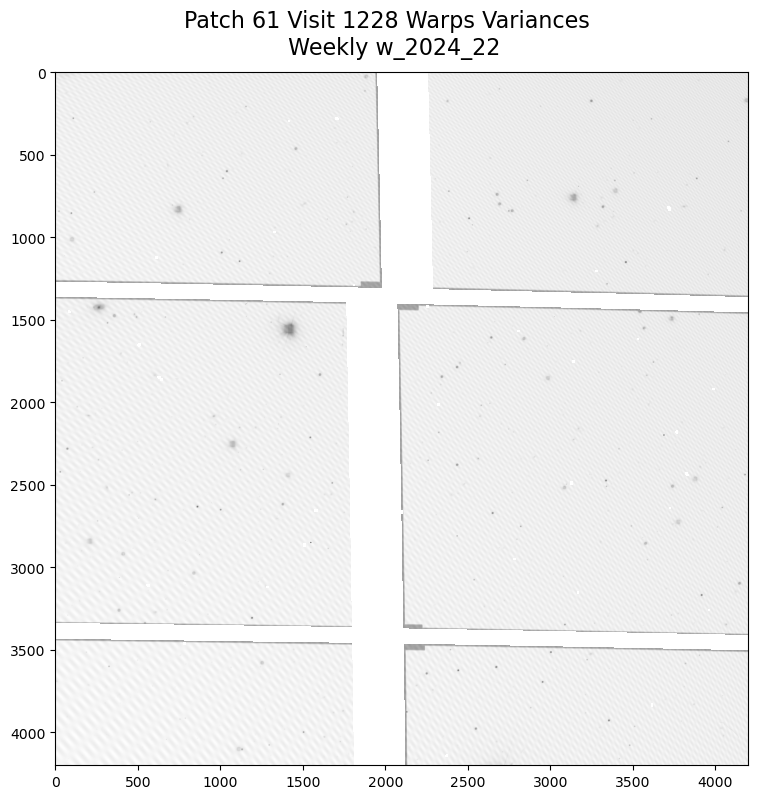

In [30]:
warp_old = butler.get('deepCoadd_directWarp',
                   collections = rc2_old_collection,
                   instrument='HSC',
                   skymap = 'hsc_rings_v1',
                   tract = 9813,
                   patch = 61,
                   visit = 1228)

fig, axs = plt.subplots(1, 1, figsize=(9,9), gridspec_kw = {'wspace':0, 'hspace':0}, sharey=True)

variance = axs.imshow(np.flip(warp_old.variance.array, axis=0),
                 cmap='gray_r',
                 norm='log',)

fig.suptitle(f"Patch {patch} Visit 1228 Warps Variance \n Weekly w_2024_22", fontsize=16, x=0.5, y=0.95)

plt.show()

### Patch 84

In [26]:
visits = []
for ref in butler.registry.queryDatasets('deepCoadd_directWarp', physical_filter='HSC-I', collections=collection, instrument='HSC', tract=9813, skymap = 'hsc_rings_cells_v1', patch=84):
    visits.append(ref.dataId.get('visit'))
visits = np.unique(visits)
print(visits)

[30482]


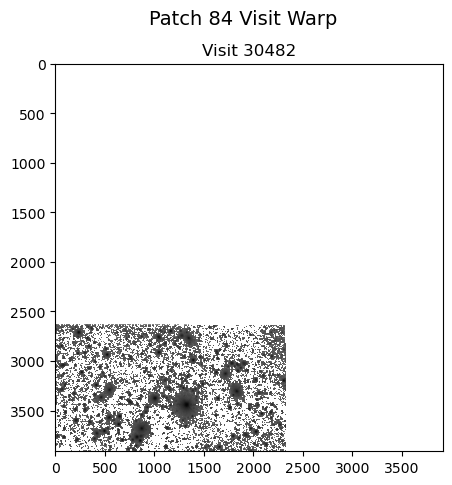

In [28]:
fig, axs = plt.subplots(1, 1, figsize=(5,7), gridspec_kw = {'wspace':0, 'hspace':0}, sharey=True)

for ax_index, ax in enumerate([axs]):

    warp = butler.get('deepCoadd_directWarp',
                   collections = collection,
                   instrument='HSC',
                   skymap = 'hsc_rings_cells_v1',
                   tract = 9813,
                   patch = 84,
                   visit = visits[ax_index])

    stitched_image = ax.imshow(np.flip(warp.image.array, axis=0),
                     cmap='gray_r',
                     norm='log',)

    ax.set_title(f"Visit {visits[ax_index]}")
    # ax.label_outer()

    del warp
    gc.collect()

fig.suptitle("Patch 84 Visit Warp", fontsize=14, x=0.5, y=0.85)
# plt.savefig('variance-wiggles-coadd-patch84.png', bbox_inches='tight')
plt.show()

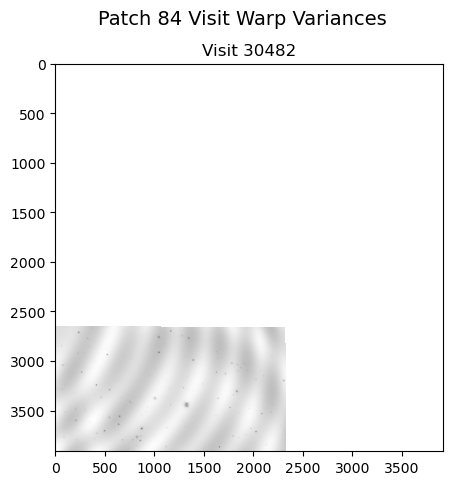

In [29]:
fig, axs = plt.subplots(1, 1, figsize=(5,7), gridspec_kw = {'wspace':0, 'hspace':0}, sharey=True)

for ax_index, ax in enumerate([axs]):

    warp = butler.get('deepCoadd_directWarp',
                   collections = collection,
                   instrument='HSC',
                   skymap = 'hsc_rings_cells_v1',
                   tract = 9813,
                   patch = 84,
                   visit = visits[ax_index])

    stitched_image = ax.imshow(np.flip(warp.variance.array, axis=0),
                     cmap='gray_r',
                     norm='log',)

    ax.set_title(f"Visit {visits[ax_index]}")
    # ax.label_outer()

    del warp
    gc.collect()

fig.suptitle("Patch 84 Visit Warp Variances", fontsize=14, x=0.5, y=0.85)
# plt.savefig('variance-wiggles-coadd-patch84.png', bbox_inches='tight')
plt.show()

## Warp Constant Variance

Visit 1242 will have 3 `calexps` from 3 detectors: [42 50 58].

Read in an example `calexp`.

In [4]:
from lsst.pipe.tasks.make_direct_warp import MakeDirectWarpTask, MakeDirectWarpConfig
from lsst.pipe.tasks.make_psf_matched_warp import MakePsfMatchedWarpTask, MakePsfMatchedWarpConfig

directWarp_config = MakeDirectWarpConfig()
directWarp_config.doWarpMaskedFraction = True
directWarp_config.doPreWarpInterpolation = True
directWarp_config.doSelectPreWarp = False
directWarp_config.useVisitSummaryPsf = False

psfWarp_config = MakePsfMatchedWarpConfig()

directWarp_task = MakeDirectWarpTask(config=directWarp_config)
psfWarp_task = MakePsfMatchedWarpTask(config=psfWarp_config)

from lsst.pipe.tasks.coaddBase import makeSkyInfo
from lsst.pipe.base import InMemoryDatasetHandle

In [5]:
sky_map = butler.get('skyMap', collections=hsc_collection, skymap='hsc_rings_cells_v1')

sky_info = makeSkyInfo(
            skyMap=sky_map,
            tractId=9813,
            patchId=61,
        )

In [6]:
detectors = [42, 50, 58]
dataRefs = []

for detector in detectors:
    calexp = butler.get('calexp', 
                     physical_filter='HSC-I', 
                     collections=hsc_collection, 
                     instrument='HSC', 
                     tract=9813,
                     patch=61,
                     visit=1242, 
                     detector = detector)

    wcs = calexp.wcs

    dataId = {'instrument': 'HSC', 'visit': 1242, 'detector': detector}
    new_dataId = registry.expandDataId(dataId)

    # change the calexp variance to a constant value
    empty_calexp = calexp.clone()

    variance = empty_calexp.getVariance().array
    empty_variance = variance.copy()
    empty_variance.fill(10)
    
    empty_calexp.variance.array = empty_variance

    dataRef = InMemoryDatasetHandle(empty_calexp, dataId=new_dataId)
    dataRefs.append(dataRef)

In [7]:
inputs = {"calexp_list": dataRefs}

In [8]:
constant_var_direct_warp = directWarp_task.run(
    inputs=inputs,
    sky_info=sky_info,
)

In [10]:
direct_warp = constant_var_direct_warp.warp

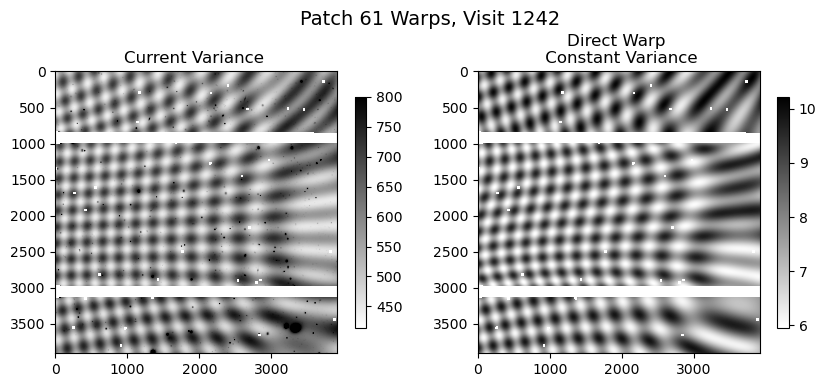

In [31]:
warp = butler.get('deepCoadd_directWarp',
                   collections = collection,
                   instrument='HSC',
                   skymap = 'hsc_rings_cells_v1',
                   tract = 9813,
                   patch = 61,
                   visit = 1242)

fig, axs = plt.subplots(1, 2, figsize=(10,5), sharey=False)

normal_warp_var = axs[0].imshow(np.flip(warp.variance.array, axis=0),
                 cmap='gray_r',
                 norm='linear',
                 vmin=np.nanmin(warp.variance.array),
                 vmax = 800)

axs[0].set_title(f"Current Variance ")
fig.colorbar(normal_warp_var, ax=axs[0], cmap='gray_r', shrink=0.6)

const_warp_var = axs[1].imshow(np.flip(direct_warp.variance.array, axis=0),
                 cmap='gray_r',
                 norm='linear',)

axs[1].set_title(f"Direct Warp \n Constant Variance")
fig.colorbar(const_warp_var, ax=axs[1], cmap='gray_r', shrink=0.6)

fig.suptitle(f"Patch {61} Warps, Visit 1242", fontsize=14, x=0.5, y=0.90)
plt.show()

#### Generating a rough method generating warps

In [36]:
def run_direct_warp_const_var(collection, tract, patch, visit, var):
    # define sky info
    sky_map = butler.get('skyMap', collections=collection, skymap='hsc_rings_cells_v1')

    sky_info = makeSkyInfo(
                skyMap=sky_map,
                tractId=tract,
                patchId=patch,
            )

    # retrieve all detectors
    detectors = []
    for ref in butler.registry.queryDatasets('calexp', 
                                             physical_filter='HSC-I', 
                                             collections=collection, 
                                             instrument='HSC', 
                                             skymap = 'hsc_rings_cells_v1',
                                             tract=tract,
                                             patch=patch,
                                             visit=visit):
        
        detectors.append(ref.dataId['detector'])

    # change each calexp variance to a constant value
    dataRefs = []
    
    for detector in detectors:
        calexp = butler.get('calexp', 
                         physical_filter='HSC-I', 
                         collections=collection, 
                         instrument='HSC', 
                         tract=tract,
                         patch=patch,
                         visit=visit, 
                         detector = detector)
    
        wcs = calexp.wcs
    
        dataId = {'instrument': 'HSC', 'visit': visit, 'detector': detector}
        new_dataId = registry.expandDataId(dataId)
    
        # change the calexp variance to a constant value
        empty_calexp = calexp.clone()
    
        variance = empty_calexp.getVariance().array
        empty_variance = variance.copy()
        empty_variance.fill(var)
        
        empty_calexp.variance.array = empty_variance
    
        dataRef = InMemoryDatasetHandle(empty_calexp, dataId=new_dataId)
        dataRefs.append(dataRef)

        del calexp
        gc.collect()

    # define task inputs
    inputs = {"calexp_list": dataRefs}

    # run the warping task
    constant_var_direct_warp = directWarp_task.run(
    inputs=inputs,
    sky_info=sky_info,)

    return constant_var_direct_warp.warp

In [37]:
warp = run_direct_warp_const_var(hsc_collection, 9813, 61, 19680, 10)

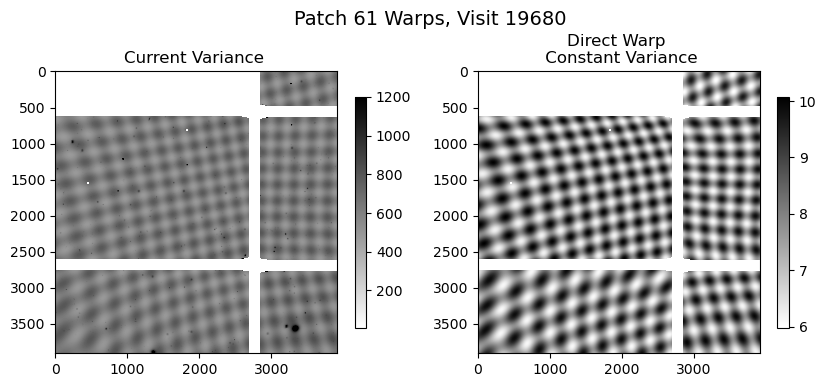

In [48]:
direct_warp = butler.get('deepCoadd_directWarp',
                   collections = collection,
                   instrument='HSC',
                   skymap = 'hsc_rings_cells_v1',
                   tract = 9813,
                   patch = 61,
                   visit = 19680)

fig, axs = plt.subplots(1, 2, figsize=(10,5), sharey=False)

normal_warp_var = axs[0].imshow(np.flip(direct_warp.variance.array, axis=0),
                 cmap='gray_r',
                 norm='linear',
                 vmin=np.nanmin(warp.variance.array),
                 vmax = 1200)

axs[0].set_title(f"Current Variance ")
fig.colorbar(normal_warp_var, ax=axs[0], cmap='gray_r', shrink=0.6)

const_warp_var = axs[1].imshow(np.flip(warp.variance.array, axis=0),
                 cmap='gray_r',
                 norm='linear',)

axs[1].set_title(f"Direct Warp \n Constant Variance")
fig.colorbar(const_warp_var, ax=axs[1], cmap='gray_r', shrink=0.6)

fig.suptitle(f"Patch {61} Warps, Visit 19680", fontsize=14, x=0.5, y=0.90)
plt.show()